# **Convolutional Neural Network**

利用卷積神經網路(CNN) 做圖像分類的任務

## **Import Packages**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder
# This is for the progress bar.
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

## **Dataset, Data Loader, and Transforms**

In [ ]:
# It is important to do data augmentation in training.

train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # add transforms
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(30),
    # kernel size、sigma
    transforms.GaussianBlur(3, 1.5),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# testing and validation don't need augmentations
# resize the PIL image and transform it into Tensor
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size gives a more stable gradient. But the GPU memory is limited
batch_size = 32

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("./food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("./food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("./food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("./food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## **Model**
照 VGG-16 定義相同架構效果不好。甚至簡單許多的架構都有差不多的準確率(最高0.55~0.6)<br/>
Pre-trained model 前幾個 epoch 的準確率就超過0.6，最高到 0.7 <br/>
-> <font color=orange> use Pre-trained model </font>

In [ ]:
class VGG_Classifier(nn.Module):
    def __init__(self):
        super(VGG_Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers
        x = self.cnn_layers(x)
        # flatten the extracted feature before going to fully-connected layers.
        x = x.flatten(1)
        # x = x.view(x.size()[0], -1)
        # The features are transformed by fully-connected layers to obtain the final logits
        x = self.fc_layers(x)
        
        return x

In [ ]:
# 用class創建dataset
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        img_data = self.data[index]
        label = int(self.targets[index])
        return img_data, label

    def __len__(self):
        return len(self.targets)

'\nclass MyDataset(Dataset):\n    def __init__(self, data, targets, transform=None):\n        self.data = data\n        self.targets = torch.LongTensor(targets)\n        self.transform = transform\n\n    def __getitem__(self, index):\n        x = self.data[index]\n        y = self.targets[index]\n\n        if self.transform:\n            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))\n            x = self.transform(x)\n\n        return x, y\n\n    def __len__(self):\n        return len(self.data)\n'

## **Training**
The function "get_pseudo_labels" is used for semi-supervised learning.<br/>
It is expected to get better performance if use unlabeled data for semi-supervised learning.

In [ ]:
def get_pseudo_labels(dataset, pre_train_loader, pre_train_model, threshold=0.95):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pre_train_model.device = device
    pre_train_model.eval()

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    ite = 0
    for batch in tqdm(data_loader):
        # 因為這邊是 unlabled data，所以第2個變數是空
        img, _ = batch

        # Forward the data 。 Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = pre_train_model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # 取出每筆資料中最大的機率
        # # filter_probs[0] is prob ； filter_probs[1] is label ； ind 是第幾筆資料其機率 > threshold(0.7)
        filter_probs = probs.max(dim=-1)
        ind = ( filter_probs[0]>=threshold ).nonzero()
        other_ind = ( filter_probs[0]<threshold ).nonzero()
        ind = ind.reshape(len(ind))
        other_ind = other_ind.reshape(len(other_ind))

        # insert unlabled data
        # other ind 是 < threshold(0.7) 的資料，方便之後重建 unlabled dataset
        insert_data = [batch[0][ind], filter_probs[1][ind]]
        remain_data = [batch[0][other_ind], batch[1][other_ind]]
        data = insert_data[0]
        targets = insert_data[1].int()
        # cuda 不能直接轉 numpy
        targets = targets.cpu().numpy()
        insert_dataset = MyDataset(data, targets)

        # construct remain_dataset, 之後加到新的 unlabled set
        data = remain_data[0]
        targets = remain_data[1].int()
        targets = targets.cpu().numpy()
        remain_dataset = MyDataset(data, targets)
        if (ite == 0):
            psuedo_set = insert_dataset
            new_unlabeled_set = remain_dataset
        else:
            psuedo_set = ConcatDataset([psuedo_set, insert_dataset])
            new_unlabeled_set = ConcatDataset([new_unlabeled_set, remain_dataset])
        ite += 1

    print('After pseudo label generate', len(psuedo_set), 'pseudo data and remain unlabeld data ', len(new_unlabeled_set))
    return psuedo_set, new_unlabeled_set

In [ ]:
%%time
# epoch 40：0.55/0.37 | epoch 45：0.65/0.38 | epoch 50：0.73/0.4  -> 所以先跑 40 個 epoch 當作 pre-train
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model = models.vgg16(pretrained=True)
model = models.resnet50(pretrained=True)
# 修改預訓練模型的輸出類別數量。原本的 output 是 1000，修改成11
my_fc_simple = nn.Sequential( nn.Linear(2048, 11) )
model.fc = my_fc_simple
model = model.to(device)

# use cross-entropy as the measurement of performance
criterion = nn.CrossEntropyLoss()
# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 75
pre_train_epoch = 3

# Whether to do semi-supervised learning.
do_semi = True

# 紀錄 acc 變化，畫圖用
train_acc_list = []
valid_acc_list = []

valid_acc = 0
valid_max = 0
not_better = 0

for epoch in range(n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)
    if valid_acc > valid_max :
        valid_max = valid_acc
        not_better = 0
    else:
        not_better += 1
    if not_better >= 10 :
        print('change learning rate ! ')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
        not_better = 0

    if do_semi and ( epoch%10 == (pre_train_epoch) ) and (valid_acc >= 0.65):
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set, unlabeled_set = get_pseudo_labels(unlabeled_set, train_loader, model)
        print('new unlabeled set ', len(unlabeled_set))
        # Construct a new dataset and a data loader for training.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    # ---------- Training ----------
    model.train()
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))
        # Calculate the cross-entropy loss.
        loss = criterion(logits, labels.to(device))
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # Update the parameters with computed gradients.
        optimizer.step()
        # Compute the accuracy for current batch.
        # argmax 會回傳每個 logit 最大值所在的 index (返回類別，1-11)
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval()
    # record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        with torch.no_grad():
          logits = model(imgs.to(device))
        
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # record the loss and accuracy
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

cuda


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 97/97 [00:19<00:00,  4.87it/s]


[ Train | 001/075 ] loss = 1.41557, acc = 0.56411


100%|██████████| 21/21 [00:02<00:00,  8.16it/s]


[ Valid | 001/075 ] loss = 1.07809, acc = 0.65476


100%|██████████| 97/97 [00:18<00:00,  5.37it/s]


[ Train | 002/075 ] loss = 0.64631, acc = 0.79220


100%|██████████| 21/21 [00:02<00:00,  8.77it/s]


[ Valid | 002/075 ] loss = 1.31931, acc = 0.60804


100%|██████████| 97/97 [00:17<00:00,  5.45it/s]


[ Train | 003/075 ] loss = 0.39594, acc = 0.87468


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


[ Valid | 003/075 ] loss = 1.38824, acc = 0.63006


100%|██████████| 97/97 [00:17<00:00,  5.45it/s]


[ Train | 004/075 ] loss = 0.27567, acc = 0.91785


100%|██████████| 21/21 [00:02<00:00,  8.72it/s]


[ Valid | 004/075 ] loss = 1.65829, acc = 0.61220


100%|██████████| 97/97 [00:17<00:00,  5.48it/s]


[ Train | 005/075 ] loss = 0.18731, acc = 0.94072


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


[ Valid | 005/075 ] loss = 1.63834, acc = 0.61935


100%|██████████| 97/97 [00:18<00:00,  5.23it/s]


[ Train | 006/075 ] loss = 0.16827, acc = 0.94716


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


[ Valid | 006/075 ] loss = 1.75989, acc = 0.61220


100%|██████████| 97/97 [00:17<00:00,  5.63it/s]


[ Train | 007/075 ] loss = 0.14046, acc = 0.95683


100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


[ Valid | 007/075 ] loss = 1.69114, acc = 0.62054


100%|██████████| 97/97 [00:18<00:00,  5.39it/s]


[ Train | 008/075 ] loss = 0.12009, acc = 0.96521


100%|██████████| 21/21 [00:02<00:00,  8.70it/s]


[ Valid | 008/075 ] loss = 1.96599, acc = 0.60863


100%|██████████| 97/97 [00:17<00:00,  5.53it/s]


[ Train | 009/075 ] loss = 0.10586, acc = 0.96521


100%|██████████| 21/21 [00:02<00:00,  8.90it/s]


[ Valid | 009/075 ] loss = 1.69964, acc = 0.64256


100%|██████████| 97/97 [00:17<00:00,  5.54it/s]


[ Train | 010/075 ] loss = 0.07300, acc = 0.97584


100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


[ Valid | 010/075 ] loss = 1.46866, acc = 0.69732


100%|██████████| 97/97 [00:17<00:00,  5.41it/s]


[ Train | 011/075 ] loss = 0.08961, acc = 0.96907


100%|██████████| 21/21 [00:02<00:00,  8.22it/s]


[ Valid | 011/075 ] loss = 1.67700, acc = 0.66875


100%|██████████| 97/97 [00:17<00:00,  5.56it/s]


[ Train | 012/075 ] loss = 0.08421, acc = 0.97004


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


[ Valid | 012/075 ] loss = 1.60395, acc = 0.66131


100%|██████████| 97/97 [00:17<00:00,  5.54it/s]


[ Train | 013/075 ] loss = 0.08124, acc = 0.97423


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


[ Valid | 013/075 ] loss = 1.57386, acc = 0.67321


100%|██████████| 213/213 [00:33<00:00,  6.45it/s]


After pseudo label generate 5127 pseudo data and remain unlabeld data  1659
new unlabeled set  1659


100%|██████████| 257/257 [00:25<00:00, 10.00it/s]


[ Train | 014/075 ] loss = 0.17191, acc = 0.94480


100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


[ Valid | 014/075 ] loss = 2.09342, acc = 0.63363


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 015/075 ] loss = 0.12102, acc = 0.95970


100%|██████████| 21/21 [00:02<00:00,  8.78it/s]


[ Valid | 015/075 ] loss = 2.36807, acc = 0.59167


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 016/075 ] loss = 0.08502, acc = 0.97240


100%|██████████| 21/21 [00:02<00:00,  8.35it/s]


[ Valid | 016/075 ] loss = 1.59081, acc = 0.69256


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 017/075 ] loss = 0.06641, acc = 0.97870


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


[ Valid | 017/075 ] loss = 1.97140, acc = 0.63810


100%|██████████| 257/257 [00:25<00:00,  9.99it/s]


[ Train | 018/075 ] loss = 0.05744, acc = 0.98042


100%|██████████| 21/21 [00:02<00:00,  8.36it/s]


[ Valid | 018/075 ] loss = 1.91841, acc = 0.65774


100%|██████████| 257/257 [00:25<00:00,  9.99it/s]


[ Train | 019/075 ] loss = 0.05629, acc = 0.98223


100%|██████████| 21/21 [00:02<00:00,  8.47it/s]


[ Valid | 019/075 ] loss = 2.45228, acc = 0.61905


100%|██████████| 257/257 [00:25<00:00,  9.96it/s]


[ Train | 020/075 ] loss = 0.04574, acc = 0.98541


100%|██████████| 21/21 [00:02<00:00,  8.55it/s]


[ Valid | 020/075 ] loss = 1.95852, acc = 0.65655
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 021/075 ] loss = 0.61207, acc = 0.81759


100%|██████████| 21/21 [00:02<00:00,  8.44it/s]


[ Valid | 021/075 ] loss = 1.04200, acc = 0.69464


100%|██████████| 257/257 [00:25<00:00,  9.93it/s]


[ Train | 022/075 ] loss = 0.19862, acc = 0.93649


100%|██████████| 21/21 [00:02<00:00,  8.35it/s]


[ Valid | 022/075 ] loss = 1.64679, acc = 0.63095


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 023/075 ] loss = 0.08715, acc = 0.97301


100%|██████████| 21/21 [00:02<00:00,  8.68it/s]


[ Valid | 023/075 ] loss = 2.36001, acc = 0.55893


100%|██████████| 257/257 [00:25<00:00,  9.95it/s]


[ Train | 024/075 ] loss = 0.06653, acc = 0.97855


100%|██████████| 21/21 [00:02<00:00,  8.49it/s]


[ Valid | 024/075 ] loss = 2.03050, acc = 0.61577


100%|██████████| 257/257 [00:25<00:00, 10.04it/s]


[ Train | 025/075 ] loss = 0.05058, acc = 0.98346


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


[ Valid | 025/075 ] loss = 2.60619, acc = 0.56935


100%|██████████| 257/257 [00:25<00:00, 10.02it/s]


[ Train | 026/075 ] loss = 0.04397, acc = 0.98504


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


[ Valid | 026/075 ] loss = 2.03015, acc = 0.63095


100%|██████████| 257/257 [00:25<00:00, 10.02it/s]


[ Train | 027/075 ] loss = 0.03885, acc = 0.98673


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


[ Valid | 027/075 ] loss = 1.91359, acc = 0.66637


100%|██████████| 257/257 [00:25<00:00, 10.01it/s]


[ Train | 028/075 ] loss = 0.03925, acc = 0.98796


100%|██████████| 21/21 [00:02<00:00,  8.65it/s]


[ Valid | 028/075 ] loss = 2.20293, acc = 0.64167


100%|██████████| 257/257 [00:25<00:00, 10.02it/s]


[ Train | 029/075 ] loss = 0.03245, acc = 0.98963


100%|██████████| 21/21 [00:02<00:00,  8.36it/s]


[ Valid | 029/075 ] loss = 3.72594, acc = 0.53363


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 030/075 ] loss = 0.02866, acc = 0.98979


100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


[ Valid | 030/075 ] loss = 3.19897, acc = 0.53810
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 031/075 ] loss = 0.35234, acc = 0.89055


100%|██████████| 21/21 [00:02<00:00,  8.32it/s]


[ Valid | 031/075 ] loss = 2.66795, acc = 0.43423


100%|██████████| 257/257 [00:25<00:00,  9.99it/s]


[ Train | 032/075 ] loss = 0.11524, acc = 0.96389


100%|██████████| 21/21 [00:02<00:00,  8.35it/s]


[ Valid | 032/075 ] loss = 2.61906, acc = 0.53631


100%|██████████| 257/257 [00:25<00:00,  9.92it/s]


[ Train | 033/075 ] loss = 0.04850, acc = 0.98261


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


[ Valid | 033/075 ] loss = 2.51837, acc = 0.59554


100%|██████████| 257/257 [00:25<00:00,  9.92it/s]


[ Train | 034/075 ] loss = 0.03853, acc = 0.98743


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


[ Valid | 034/075 ] loss = 1.76184, acc = 0.65387


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 035/075 ] loss = 0.03293, acc = 0.98966


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


[ Valid | 035/075 ] loss = 2.69614, acc = 0.54137


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 036/075 ] loss = 0.02902, acc = 0.99137


100%|██████████| 21/21 [00:02<00:00,  8.74it/s]


[ Valid | 036/075 ] loss = 3.24905, acc = 0.54613


100%|██████████| 257/257 [00:25<00:00,  9.95it/s]


[ Train | 037/075 ] loss = 0.02461, acc = 0.99184


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


[ Valid | 037/075 ] loss = 3.91989, acc = 0.50893


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 038/075 ] loss = 0.02716, acc = 0.99137


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


[ Valid | 038/075 ] loss = 3.07299, acc = 0.55089


100%|██████████| 257/257 [00:25<00:00,  9.96it/s]


[ Train | 039/075 ] loss = 0.02467, acc = 0.99170


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


[ Valid | 039/075 ] loss = 2.78513, acc = 0.59048


100%|██████████| 257/257 [00:25<00:00, 10.04it/s]


[ Train | 040/075 ] loss = 0.02035, acc = 0.99246


100%|██████████| 21/21 [00:02<00:00,  8.42it/s]


[ Valid | 040/075 ] loss = 2.67063, acc = 0.59643
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00, 10.00it/s]


[ Train | 041/075 ] loss = 0.24363, acc = 0.92274


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


[ Valid | 041/075 ] loss = 3.06623, acc = 0.46815


100%|██████████| 257/257 [00:25<00:00, 10.00it/s]


[ Train | 042/075 ] loss = 0.08453, acc = 0.97322


100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


[ Valid | 042/075 ] loss = 2.20377, acc = 0.58244


100%|██████████| 257/257 [00:25<00:00, 10.03it/s]


[ Train | 043/075 ] loss = 0.03612, acc = 0.98868


100%|██████████| 21/21 [00:02<00:00,  8.45it/s]


[ Valid | 043/075 ] loss = 2.27814, acc = 0.60208


100%|██████████| 257/257 [00:25<00:00, 10.02it/s]


[ Train | 044/075 ] loss = 0.03280, acc = 0.98965


100%|██████████| 21/21 [00:02<00:00,  8.54it/s]


[ Valid | 044/075 ] loss = 2.81692, acc = 0.57530


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 045/075 ] loss = 0.02252, acc = 0.99319


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


[ Valid | 045/075 ] loss = 3.70513, acc = 0.51994


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 046/075 ] loss = 0.02622, acc = 0.99050


100%|██████████| 21/21 [00:02<00:00,  8.68it/s]


[ Valid | 046/075 ] loss = 2.64849, acc = 0.59702


100%|██████████| 257/257 [00:25<00:00,  9.90it/s]


[ Train | 047/075 ] loss = 0.02262, acc = 0.99246


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


[ Valid | 047/075 ] loss = 2.36121, acc = 0.61905


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 048/075 ] loss = 0.01672, acc = 0.99489


100%|██████████| 21/21 [00:02<00:00,  8.47it/s]


[ Valid | 048/075 ] loss = 2.64902, acc = 0.59702


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 049/075 ] loss = 0.01765, acc = 0.99465


100%|██████████| 21/21 [00:02<00:00,  8.49it/s]


[ Valid | 049/075 ] loss = 2.23161, acc = 0.64256


100%|██████████| 257/257 [00:25<00:00,  9.93it/s]


[ Train | 050/075 ] loss = 0.01909, acc = 0.99416


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


[ Valid | 050/075 ] loss = 2.81207, acc = 0.60387
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00,  9.93it/s]


[ Train | 051/075 ] loss = 0.22190, acc = 0.92993


100%|██████████| 21/21 [00:02<00:00,  8.27it/s]


[ Valid | 051/075 ] loss = 1.67848, acc = 0.61042


100%|██████████| 257/257 [00:25<00:00,  9.95it/s]


[ Train | 052/075 ] loss = 0.06718, acc = 0.97870


100%|██████████| 21/21 [00:02<00:00,  8.35it/s]


[ Valid | 052/075 ] loss = 2.35829, acc = 0.60476


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 053/075 ] loss = 0.02561, acc = 0.99137


100%|██████████| 21/21 [00:02<00:00,  8.68it/s]


[ Valid | 053/075 ] loss = 2.83124, acc = 0.59554


100%|██████████| 257/257 [00:25<00:00,  9.99it/s]


[ Train | 054/075 ] loss = 0.02512, acc = 0.99125


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


[ Valid | 054/075 ] loss = 2.91070, acc = 0.59435


100%|██████████| 257/257 [00:25<00:00,  9.96it/s]


[ Train | 055/075 ] loss = 0.01935, acc = 0.99319


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


[ Valid | 055/075 ] loss = 2.47386, acc = 0.64940


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 056/075 ] loss = 0.01629, acc = 0.99465


100%|██████████| 21/21 [00:02<00:00,  8.47it/s]


[ Valid | 056/075 ] loss = 1.92370, acc = 0.68155


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 057/075 ] loss = 0.01710, acc = 0.99465


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


[ Valid | 057/075 ] loss = 2.53086, acc = 0.62173


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 058/075 ] loss = 0.01589, acc = 0.99380


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


[ Valid | 058/075 ] loss = 3.86895, acc = 0.54762


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 059/075 ] loss = 0.01613, acc = 0.99562


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


[ Valid | 059/075 ] loss = 2.92768, acc = 0.62054


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 060/075 ] loss = 0.01699, acc = 0.99514


100%|██████████| 21/21 [00:02<00:00,  8.50it/s]


[ Valid | 060/075 ] loss = 3.74073, acc = 0.59881
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00, 10.04it/s]


[ Train | 061/075 ] loss = 0.17987, acc = 0.94492


100%|██████████| 21/21 [00:02<00:00,  8.47it/s]


[ Valid | 061/075 ] loss = 2.23628, acc = 0.55000


100%|██████████| 257/257 [00:25<00:00, 10.00it/s]


[ Train | 062/075 ] loss = 0.05990, acc = 0.98174


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


[ Valid | 062/075 ] loss = 2.15193, acc = 0.57589


100%|██████████| 257/257 [00:25<00:00,  9.99it/s]


[ Train | 063/075 ] loss = 0.02350, acc = 0.99281


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


[ Valid | 063/075 ] loss = 2.03842, acc = 0.63452


100%|██████████| 257/257 [00:25<00:00, 10.00it/s]


[ Train | 064/075 ] loss = 0.02398, acc = 0.99185


100%|██████████| 21/21 [00:02<00:00,  8.60it/s]


[ Valid | 064/075 ] loss = 2.90590, acc = 0.55357


100%|██████████| 257/257 [00:25<00:00, 10.03it/s]


[ Train | 065/075 ] loss = 0.01843, acc = 0.99404


100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


[ Valid | 065/075 ] loss = 2.82284, acc = 0.56548


100%|██████████| 257/257 [00:25<00:00,  9.96it/s]


[ Train | 066/075 ] loss = 0.01194, acc = 0.99587


100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


[ Valid | 066/075 ] loss = 2.91735, acc = 0.56548


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 067/075 ] loss = 0.01304, acc = 0.99599


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


[ Valid | 067/075 ] loss = 3.21779, acc = 0.55387


100%|██████████| 257/257 [00:26<00:00,  9.63it/s]


[ Train | 068/075 ] loss = 0.01650, acc = 0.99524


100%|██████████| 21/21 [00:02<00:00,  8.35it/s]


[ Valid | 068/075 ] loss = 2.58061, acc = 0.59196


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 069/075 ] loss = 0.01064, acc = 0.99719


100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


[ Valid | 069/075 ] loss = 3.04337, acc = 0.54970


100%|██████████| 257/257 [00:26<00:00,  9.88it/s]


[ Train | 070/075 ] loss = 0.01331, acc = 0.99599


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


[ Valid | 070/075 ] loss = 3.35887, acc = 0.54554
change learning rate ! 


100%|██████████| 257/257 [00:25<00:00,  9.98it/s]


[ Train | 071/075 ] loss = 0.16735, acc = 0.95157


100%|██████████| 21/21 [00:02<00:00,  8.29it/s]


[ Valid | 071/075 ] loss = 1.55886, acc = 0.64702


100%|██████████| 257/257 [00:25<00:00,  9.91it/s]


[ Train | 072/075 ] loss = 0.04999, acc = 0.98577


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


[ Valid | 072/075 ] loss = 3.01895, acc = 0.55119


100%|██████████| 257/257 [00:25<00:00,  9.94it/s]


[ Train | 073/075 ] loss = 0.02400, acc = 0.99246


100%|██████████| 21/21 [00:02<00:00,  8.14it/s]


[ Valid | 073/075 ] loss = 3.93277, acc = 0.49286


100%|██████████| 257/257 [00:25<00:00,  9.96it/s]


[ Train | 074/075 ] loss = 0.01650, acc = 0.99453


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


[ Valid | 074/075 ] loss = 3.16191, acc = 0.59018


100%|██████████| 257/257 [00:25<00:00,  9.97it/s]


[ Train | 075/075 ] loss = 0.01448, acc = 0.99538


100%|██████████| 21/21 [00:02<00:00,  8.62it/s]

[ Valid | 075/075 ] loss = 3.44497, acc = 0.55268
CPU times: total: 4h 32min 32s
Wall time: 34min 11s


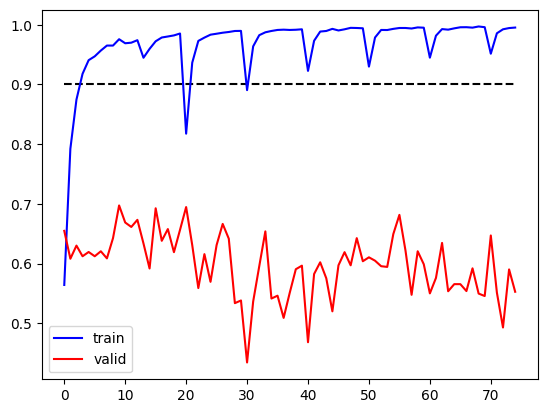

In [ ]:
# 畫圖觀察準確率的變化
epoch_list = range(0, n_epochs)
acc_90 = [0.9] * n_epochs
acc_60 = [0.6] * n_epochs
train_plot = []
valid_plot = []
for i in range(len(train_acc_list)):
    train_plot.append(train_acc_list[i].item())
    valid_plot.append(valid_acc_list[i].item())

from turtle import color
import matplotlib.pyplot as plt
plt.plot(epoch_list, acc_90, 'k--')
plt.plot(epoch_list, acc_60, 'k--')
plt.plot(epoch_list, train_plot, color='b', label='train')
plt.plot(epoch_list, valid_plot, color='r', label = 'valid')
plt.legend()
plt.show()

## **Testing**

In [ ]:
model.eval()
# store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless do not have the ground-truth.
    # If printing out the labels, it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


In [ ]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")